# Building a Controller

The following documents the development of a new controller.
In this case we are going to implement an arbitrary controllable storage unit. This
may be a battery, an electrically powered car or some sort of reservoir storage.

## Modelling a Battery

In order to simulate a storage system we use the storage element of pandapower. The power of a storage can be positive or negative. To overcome this issue, a storage element can be created. 

For storage elements the signing is based on the consumer viewpoint (positive active power means power consumption and therefore charging of the battery).

As pandapower is not a time dependend simulation tool and there is no time domain parameter in default power flow calculations, the state of charge (SoC) is not updated during any power flow calculation. 
In Order to update the SoC we build our own storage controller and keep track of the SoC.

State of charge (SoC [\%]) is the level of charge of an electric battery relative to its capacity.


## Controller init
First we start by creating a new file *control/storage_control.py*, containing our new class.

Import and inherit from the parent class `Controller` and override methods you would like to use. Next we write the actual code for the methods.

In [3]:
import pandapower as pp
from pandapower import control
import pandas as pd
from pandapower import timeseries as ts

# importing a grid from the library
from pandapower.networks import mv_oberrhein


class Storage(control.basic_controller.Controller):
    """
        Example class of a Storage-Controller. Models an abstract energy storage.
    """
    def __init__(self, net, element_index, data_source=None, p_profile=None, in_service=True,
                 recycle=False, order=0, level=0, **kwargs):
        super().__init__(net, in_service=in_service, recycle=recycle, order=order, level=level,
                    initial_powerflow = True, **kwargs)
        
        # read generator attributes from net
        self.element_index = element_index  # index of the controlled storage
        self.bus = net.storage.at[element_index, "bus"]
        self.p_mw = net.storage.at[element_index, "p_mw"]
        self.q_mvar = net.storage.at[element_index, "q_mvar"]
        self.sn_mva = net.storage.at[element_index, "sn_mva"]
        self.name = net.storage.at[element_index, "name"]
        self.gen_type = net.storage.at[element_index, "type"]
        self.in_service = net.storage.at[element_index, "in_service"]
        self.applied = False

        # specific attributes
        self.max_e_mwh = net.storage.at[element_index, "max_e_mwh"]
        self.soc_percent = net.storage.at[element_index, "soc_percent"] = 0
        
        # profile attributes
        self.data_source = data_source
        self.p_profile = p_profile
        self.last_time_step = None
        
    # We choose to represent the storage-unit as a storage element in pandapower. 
    # We start with a function calculating the amout of stored energy:    
    def get_stored_ernergy(self):
        # calculating the stored energy
        return self.max_e_mwh * self.soc_percent / 100        
    
    # convergence check
    # Also remember that 'is_converged()' returns the boolean value of convergence:
    def is_converged(self, net):
        # check if controller already was applied
        return self.applied
    
    # Also a first step we want our controller to be able to write its P and Q and state of charge values back to the
    # data structure net.
    def write_to_net(self, net):
        # write p, q and soc_percent to bus within the net
        net.storage.at[self.element_index, "p_mw"] = self.p_mw
        net.storage.at[self.element_index, "q_mvar"] = self.q_mvar
        net.storage.at[self.element_index, "soc_percent"]= self.soc_percent
        
    # In case the controller is not yet converged, the control step is executed. In the example it simply
    # adopts a new value according to the previously calculated target and writes back to the net.
    def control_step(self, net):
        # Call write_to_net and set the applied variable True
        self.write_to_net(net)
        self.applied = True
        
    # In a time-series simulation the battery should read new power values from a profile and keep track
    # of its state of charge as depicted below.
    def time_step(self, net, time):
        # keep track of the soc (assuming time is given in 15min values)
        if self.last_time_step is not None:
            # The amount of Energy produce or consumed in the last timestep is added relative to the 
            # maximum of the possible stored energy
            self.soc_percent += (self.p_mw * (time-self.last_time_step) * 15 / 60) / self.max_e_mwh * 100
        self.last_time_step = time

        # read new values from a profile
        if self.data_source:
            if self.p_profile is not None:
                self.p_mw = self.data_source.get_time_step_value(time_step=time,
                                                                profile_name=self.p_profile)
                
        self.applied = False # reset applied variable

We are now ready to create objects of our newly implemented class and simulate with it!

In [4]:
# importing a grid from the library
from pandapower.networks import mv_oberrhein

# loading the network with the usecase 'generation'
net = mv_oberrhein()
pp.runpp(net)

# creating a simple time series
framedata = pd.DataFrame([0.1, .05, 0.1, .005, -0.2, 0], columns=['P'])
datasource = ts.DFData(framedata)

# creating storage unit in the grid, which will be controlled by our controller
store_el = pp.create_storage(net, 30, p_mw = .1, q_mvar = 0, max_e_mwh = 0.1, )

# creating an Object of our new build storage controller, controlling the storage unit
ctrl = Storage(net=net, element_index=store_el, data_source=datasource,p_profile='P')

hp.pandapower.io_utils - WARNING: pandapowerNet-version (3.0.0) is newer than your pandapower version (2.15.0). Please update pandapower `pip install --upgrade pandapower`.
hp.pandapower.control.util.auxiliary - INFO: Creating controller 0 of type <class '__main__.Storage'> 


Now we run a small time-series-simulation and track the results using the outputwriter:

In [5]:
# defining an OutputWriter to track certain variables
ow = ts.OutputWriter(net)

ow.log_variable("res_storage", "p_mw")
ow.log_variable("storage", "soc_percent")

# starting time series simulation
ts.run_timeseries(net, time_steps=range(0, 6))

100%|██████████| 6/6 [00:00<00:00, 20.77it/s]


To visualize the results we plot directly with the dataframe:

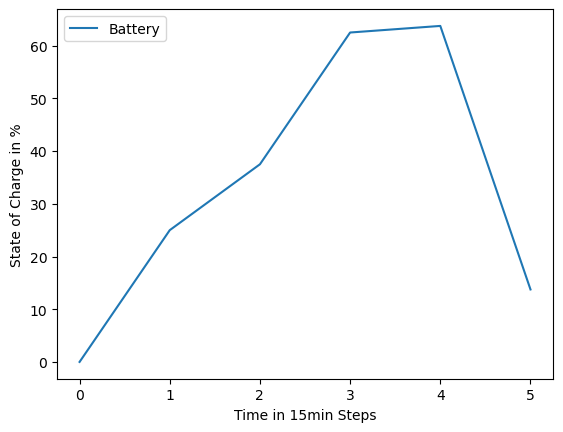

In [6]:
# plotting the state of charge
ow.output['storage.soc_percent'].columns = ['Battery']
ax = ow.output['storage.soc_percent'].plot()
ax.set_xlabel('Time in 15min Steps')
ax.set_ylabel('State of Charge in %')
ax.legend()

The state of charge grows until a certain point and drops in the end following the give values from the timeseries. The time windows between each timestep and the reactive power values define the amount of stored or consumed energy.

In the shown case a SoC of more than 100\% would be possible, because the SoC just gets summed up.
To make the controller more realistic you could implement tresholds for the SoC and different initial SoC-values. Try to experiment!